In [1]:
code_dir = "../UXO_protected/+BTInvertPY"

In [2]:
import sys
sys.path.append(code_dir)

from BTSensor import (
    SensorInfo, Model, preCalcLoopCorners, FModParam, 
    forwardWithQ, sensorCoords2RxCoords, hprimary, formQmatrix,
)
import numpy as np
import os
import h5py
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib import colors
from matplotlib.colors import Normalize
from mpl_toolkits import mplot3d

In [3]:
from matplotlib import rcParams
rcParams['font.size'] = 14
np.random.seed(2020)

In [4]:
afile = os.path.join(code_dir,'config','sensor_definitions','UltraTEMArrayNA___Default.yaml')
sensorinfo = SensorInfo.fromYAML(afile)[0]

## set up survey parameters
- x is cross-line
- y is inline

In [5]:
ntx = len(sensorinfo.transmitters)
ymax = 5
dy = 0.2 / ntx
nloc = int(ymax/dy)
ncycles = int(nloc/ntx)

y = np.linspace(0, ymax-dy, nloc)
x = np.zeros(nloc)
z = 0.28 * np.ones(nloc)

pitch = np.zeros(nloc)
roll = np.zeros(nloc)
yaw = np.zeros(nloc)  # moving north (sensor in typical orientation)

txnum = np.kron(np.ones(ncycles), np.arange(ntx))

In [6]:
nloc/ntx

25.0

In [7]:
# Convert sensor location coordinates to Rx locations
pos, mnum = sensorCoords2RxCoords(
    sensorinfo=sensorinfo,
    x = x, 
    y = y, 
    z = z, 
    pitch = pitch, 
    roll = roll, 
    yaw = yaw,
    txnum = txnum
)

pitch = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(pitch)])
roll = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(roll)])
yaw = np.concatenate([np.tile(x,pos[i].shape[0]) for i,x in enumerate(yaw)])
pos = np.concatenate(pos,axis=0)

In [8]:
for i in range(3):
    print(pos[:, i].min(), pos[:, i].max())

-1.0 1.0
-0.25 5.21
0.28 0.28


# ordnance objects

In [9]:
filename = "ordnance_DoD_UltraTEM_5F_APG.h5"
ord_file = os.path.join(code_dir, filename)
f = h5py.File(ord_file, 'r')

In [10]:
f["ordnance"]["1"]

<HDF5 group "/ordnance/1" (27 members)>

In [11]:
# Load the ordnance objects

def load_ord(filename="ordnance_DoD_UltraTEM_5F_ISOsmall.h5", ordi=1):
    ord_file = os.path.join(code_dir, filename)
    f = h5py.File(ord_file, 'r')
    ord_name = str(f['ordnance/{}/Name'.format(ordi)][()][0]).split("'")[1]
    ord_dict = {
        "L3": f[f'ordnance/{ordi}/L1ref'][()].flatten(),
        "L2": f[f'ordnance/{ordi}/L2ref'][()].flatten(),
        "L1": f[f'ordnance/{ordi}/L3ref'][()].flatten(),
        "times": f[f'ordnance/{ordi}/time'][()].flatten()
    }
    f.close()
    return ord_name, ord_dict

In [12]:
ordnance = {}
for f in ["ordnance_DoD_UltraTEM_5F_ISOsmall.h5", "ordnance_DoD_UltraTEM_5F_APG.h5"]:
    name, data = load_ord(f)
    ordnance[name] = data
times = ordnance["ISO Small"]["times"]

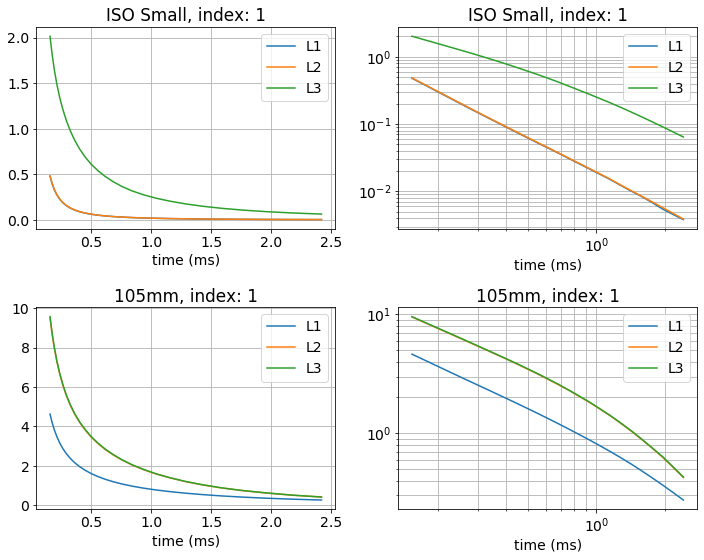

In [13]:
fig, ax = plt.subplots(len(ordnance.keys()), 2, figsize=(10, 4*len(ordnance.keys())))

for i, key in enumerate(ordnance.keys()):
    for l in ["L1", "L2", "L3"]:
        L = ordnance[key][l]
        ax[i, 0].plot(times, L, label=l)
        ax[i, 1].loglog(times, L, label=l)

    for a in ax[i, :]:
        a.set_title(f"{key}, index: {1}")
        a.grid(which="both")
        a.legend()
        a.set_xlabel("time (ms)")
plt.tight_layout()

# ranges of parameters

In [14]:
depth_range_iso_small = np.r_[0.2, 0.7]
depth_range_105mm = np.r_[0.1, 0.5]

x_range = np.r_[-1.25, 1.25]
y_range = np.r_[0., ymax]

yaw_range = np.r_[0, 2*np.pi]
pitch_range = np.r_[0, 2*np.pi]
roll_range = np.r_[0, 2*np.pi]

def generate_random_variables(n, bounds):
    return bounds.min() + (bounds.max() - bounds.min()) * np.random.rand(n)

In [15]:
ntrain = 512
ntest = 128
nvalid = 128

class_dict = {
    0: "not TOI",
    1: "ISO Small",
    2: "105mm"
}
n_class = len(class_dict.keys())

In [16]:
labels_train = np.random.choice(n_class, ntrain)
labels_test = np.random.choice(n_class, ntest)
labels_valid = np.random.choice(n_class, nvalid)

def generate_parameters(labels):
    n = len(labels)
    i0 = labels == 0
    i1 = labels == 1
    i2 = labels == 2
    
    depths = np.zeros(n)
    depths[i1] = generate_random_variables(i1.sum(), depth_range_iso_small)
    depths[i2] = generate_random_variables(i2.sum(), depth_range_105mm)
    
    x = generate_random_variables(n, x_range)
    y = generate_random_variables(n, y_range)
    z = -depths
    
    yaw = generate_random_variables(n, yaw_range)
    pitch = generate_random_variables(n, pitch_range)
    roll = generate_random_variables(n, roll_range)
    
    return pd.DataFrame({
        "label": labels,
        "depth": depths,
        "x": x,
        "y": y,
        "z": z,
        "yaw": yaw,
        "pitch": pitch,
        "roll": roll
    })

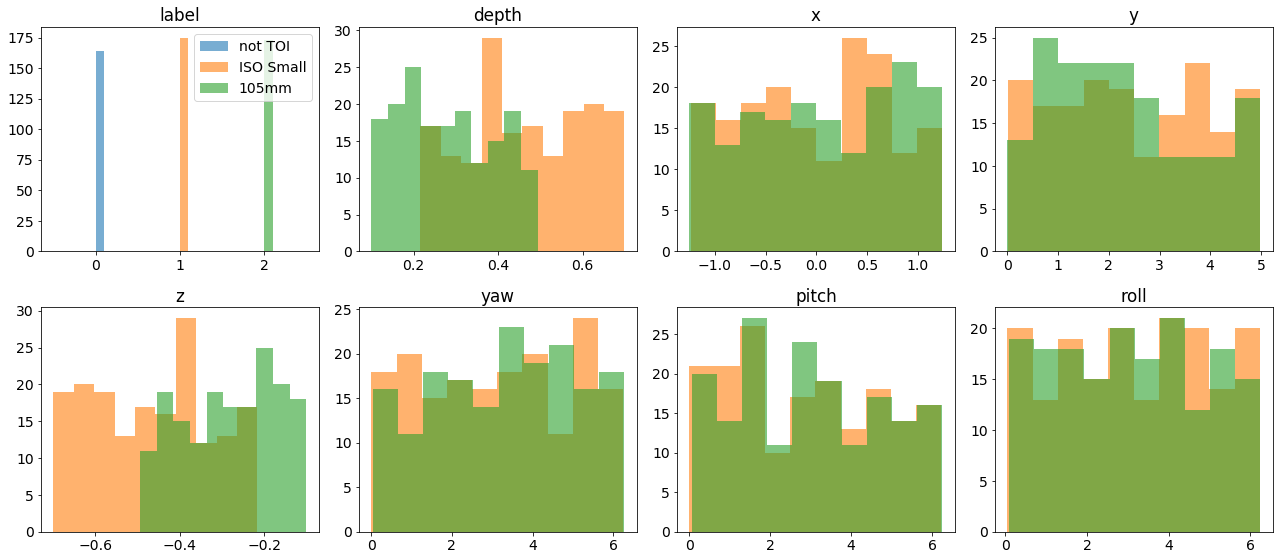

In [17]:
params_train = generate_parameters(labels_train) 
params_test = generate_parameters(labels_test) 
params_valid = generate_parameters(labels_valid) 

fig, ax = plt.subplots(2, 4, figsize=(18, 8))
ax = ax.flatten()

i = 0
for key, val in params_train.items():
    for j in range(3):
        if key != "label" and j ==0: 
            pass  # these parameters are irrelevant if there is no object
        else:
            inds = labels_train == j
            ax[i].hist(val[inds], 10, color=f"C{j}", alpha=0.6)
    ax[i].set_title(key)
    i += 1

ax[0].legend([class_dict[0], class_dict[1], class_dict[2]])
plt.tight_layout()

# set up forward simulations

In [18]:
# figuring out where all of the vertices are in coordinate system -- gives us location of vertices 
Tx_indices_rot, Rx_indices_rot = preCalcLoopCorners(
    sensorinfo=sensorinfo, mnum=mnum, rlist=pos, pitch=pitch, roll=roll, yaw=yaw
) 

# convienence object for inputs to fwd modelling 
st = FModParam(sensorinfo, pos, mnum, times, Tx_indices_rot, Rx_indices_rot)  

In [19]:
def run_simulations(parameters):
    data = []
    for i, l in enumerate(parameters["label"]):
        if l == 0:
            # this can later be replaced with random noise or other structured but uninteresting signal
            V = np.zeros((pos.shape[0], len(times)))
        else: 
            xyz = np.r_[parameters["x"][i], parameters["y"][i], parameters["z"][i]]
            ypr = np.r_[parameters["yaw"][i], parameters["pitch"][i], parameters["roll"][i]]
            L3 = ordnance[class_dict[l]]["L3"]
            L2 = ordnance[class_dict[l]]["L2"]
            L1 = ordnance[class_dict[l]]["L1"]
            
            mod = Model(xyz=xyz, gba=ypr, l3=L3, l2=L2, l1=L1, times=times)
            V = forwardWithQ(mod, st) # nT/s (some version of db/dt)
        V = V.reshape(ncycles, mnum.max()+1, len(times))
        V = np.swapaxes(V, 0, 1)
        data.append(V)
    return data
    
    

In [20]:
%%time
data_train = run_simulations(params_train)

CPU times: user 2.94 s, sys: 479 ms, total: 3.42 s
Wall time: 581 ms


In [21]:
%%time
data_test = run_simulations(params_test)
data_valid = run_simulations(params_valid)

CPU times: user 1.58 s, sys: 270 ms, total: 1.85 s
Wall time: 316 ms


## plot some sample data

In [22]:
pos = np.swapaxes(pos.reshape(ncycles, mnum.max()+1, 3), 0, 1)

In [23]:
dind = 3
d = data_train[dind]

print(f"class: {class_dict[labels_train[dind]]}, data shape: {d.shape}")

params_train.iloc[dind]

class: ISO Small, data shape: (165, 25, 27)


label    1.000000
depth    0.666309
x       -0.470353
y        0.342145
z       -0.666309
yaw      6.094564
pitch    2.877988
roll     5.914642
Name: 3, dtype: float64

In [24]:
# tx_num, rx_num, rx_comp, rxcube
sensor_table = sensorinfo.measNum2TxRxRxcCube()

In [25]:
len(sensor_table)

165

Text(0.5, 0.92, 'Transmitter 5, Target 3: ISO Small')

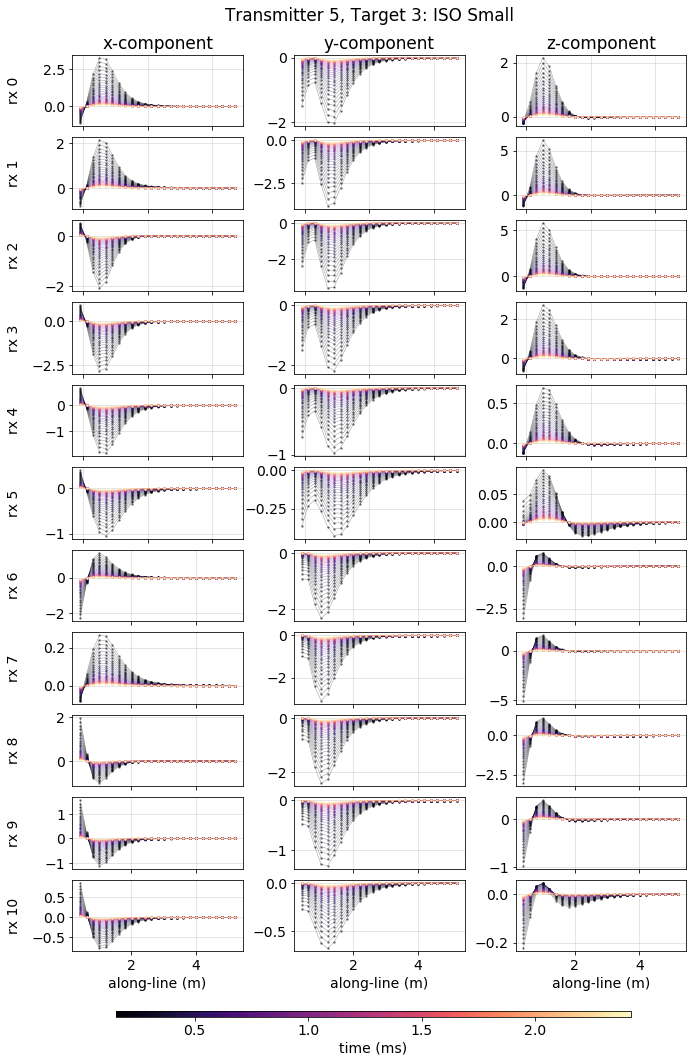

In [26]:
nrx = 11
fig, ax = plt.subplots(nrx, 3, figsize=(11, 1.5*nrx))
fig.subplots_adjust(wspace=0.3, hspace=0.15)

plot_tx = 4
tx_inds = (sensor_table[:, 0] == plot_tx)

cm = plt.get_cmap('magma')
c_norm = Normalize(vmin=times.min(), vmax=times.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

for rx in range(nrx):
    ii = tx_inds & (sensor_table[:, 3] == rx)
    for a, comp in zip(ax[rx, :], [0, 1, 2]):
        mnumind = np.where( ii & (sensor_table[:, 2] == comp))[0][0]
        for t in range(len(times)):
            a.plot(
                pos[mnumind, :, 1], d[mnumind, :, t], 
                color=scalar_map.to_rgba(times[t]), marker=".", lw=0.5, alpha=0.4, ms=3
            )

        a.grid(which="both", alpha=0.4)
        if rx < nrx-1:
            a.set_xticklabels('')
        else:
            a.set_xlabel("along-line (m)")
        
        if rx == 0:
            if comp == 0:
                a.set_title("x-component")
            elif comp == 1:
                a.set_title("y-component")
            elif comp == 2:
                a.set_title("z-component")
        
        if comp == 0:
            a.set_ylabel(f"rx {rx}")
            a.yaxis.set_label_coords(-0.3, 0.5)
            
# plt.tight_layout()
cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (ms)')

fig.suptitle(f"Transmitter {plot_tx+1}, Target {dind}: {class_dict[labels_train[dind]]}", y=0.92)


# build a CNN classifier 

In [27]:
import torch
from torch import nn
from torch.nn import functional

In [28]:
class ConvNet(nn.Module):
    
    def __init__(self, network_geometry, h=1):
        super().__init__()
        self.h = h
        self.network_geometry=network_geometry
        self.nt = len(network_geometry)
    
    def forward(self, X, K, batch_norm):
            
        for i, Ki, bn in zip(range(self.nt), K, batch_norm): 
            z = functional.conv2d(X, Ki, stride=1, padding=1)
            z = bn(z)
            z = functional.relu(z)
                
#             if self.network_geometry[i] == self.network_geometry[i+1]:
#                 z = functional.conv_transpose2d(z, Ki, stride=1, padding=1)
#                 X = X - self.h*z
#             else: 
            X = z
        return X

In [29]:
in_channels = 165
n_class = 3
layer_geometries = [in_channels, 3]
nlayers = len(layer_geometries)
initial_scaling = 1

width = nloc//ntx
ntimes = len(times)

batch_size = 32 
net = ConvNet(layer_geometries, h=1)

# initialize K's and batch normalizations
K = []
batch_norm = []
for i in range(nlayers-1):
    n_in = layer_geometries[i]
    n_out = layer_geometries[i+1]
    Ki = nn.Parameter(torch.Tensor(n_out, n_in, 3, 3))
    Ki.data = torch.randn(n_out, n_in, 3, 3)  * initial_scaling
    K.append(Ki)
    
    batch_norm.append(nn.BatchNorm2d(n_out))

# initialize classifier W
W = nn.Parameter(torch.Tensor(layer_geometries[-1]*width*ntimes, n_class))
W.data = torch.randn(layer_geometries[-1]*width*ntimes, n_class)

In [30]:
net = ConvNet(layer_geometries)

In [31]:
X_train = torch.from_numpy(np.float32(np.stack(data_train, axis=0)))
X_test = torch.from_numpy(np.float32(np.stack(data_test, axis=0)))
X_valid = torch.from_numpy(np.float32(np.stack(data_valid, axis=0)))

C_train = torch.from_numpy(np.float32(labels_train)).long()
C_test = torch.from_numpy(np.float32(labels_test)).long()
C_valid = torch.from_numpy(np.float32(labels_valid)).long()

In [32]:
# run the network

with torch.no_grad():
    out = net(X_train, K, batch_norm)

In [33]:
loss_func = nn.CrossEntropyLoss()

def misfit(X, W, C):
    n = W.shape
    X = X.view(-1, n[0])
    S = torch.matmul(X, W)

    probs = functional.softmax(S, dim=1)
    return loss_func(S, C), probs

In [34]:
n_parout = (
    np.sum(np.array([np.prod(Ki.shape) for Ki in K])) + np.prod(W.shape)
)

print('Total number of parameters',n_parout)
print('Total number of data', labels_train.shape[0])

Total number of parameters 10530
Total number of data 512


In [35]:
loss, probs = misfit(out, W, C_train)
print('Initial loss = ', loss.detach().numpy())    
print(f'Check:log({n_class}) = ', np.log(n_class))

Initial loss =  11.649349
Check:log(3) =  1.0986122886681098


In [36]:
batch_size = 16

In [37]:
import torch.optim as optim
optimizer = optim.SGD(
    [{'params': W}, {'params': K}], 
    lr = 1e0, momentum=0
)


In [38]:
all_loss = []
all_test_loss = []

for epoch in range(100):  # loop over the dataset multiple times

    # zero the parameter gradients
    g = 0.0
    loss = 0.0
    ind = 0
    
    while ind < X_train.shape[1]:    
        optimizer.zero_grad()
        # get the inputs
        inputs = X_train[ind:ind+batch_size, :, :, :]
        labels = C_train[ind:ind+batch_size]

        # forward 
        x = net(inputs, K, batch_norm)
        lossi, _ = misfit(x, W, labels)
        if i==0:
            loss = lossi
        else:
            loss += lossi
        lossi.backward()
        optimizer.step()
        ind += batch_size
    
    with torch.no_grad():
        xtest = net(X_valid, K, batch_norm)
        loss_test, _ = misfit(xtest, W, C_test)
        
    print(f'{epoch+1:d}  {loss:0.3f}  {loss_test:0.3f}')

print('Finished Training')

1  4.719  26.490
2  4.822  36.238
3  1.250  34.225
4  0.747  34.477
5  0.184  37.851
6  0.177  38.286
7  0.848  35.384
8  0.391  38.595
9  0.306  38.598
10  0.208  39.247
11  0.256  38.569
12  0.206  39.330
13  0.345  38.181
14  0.186  38.528
15  0.192  38.425
16  0.189  38.595
17  0.191  38.731
18  0.197  38.893
19  0.201  39.053
20  0.204  39.193
21  0.224  39.267
22  0.225  39.281
23  0.222  39.274
24  0.217  39.267
25  0.210  39.269
26  0.208  39.272
27  0.205  39.285
28  0.203  39.302
29  0.200  39.338
30  0.199  39.365
31  0.200  39.376
32  0.199  39.404
33  0.198  39.437
34  0.198  39.463
35  0.197  39.503
36  0.197  39.532
37  0.196  39.575
38  0.196  39.605
39  0.194  39.646
40  0.194  39.673
41  0.193  39.711
42  0.193  39.744
43  0.193  39.764
44  0.191  39.806
45  0.191  39.819
46  0.190  39.855
47  0.189  39.879
48  0.188  39.902
49  0.187  39.932
50  0.186  39.954
51  0.185  39.975
52  0.184  40.004
53  0.182  40.027
54  0.181  40.059
55  0.180  40.083
56  0.178  40.116
5

In [39]:
def accuracy(S, labels):
    _, predicted = torch.max(S, dim=1)
    total = np.prod(labels.size())
    correct = (predicted == labels).sum().item()
    return correct/total

In [40]:
# training set
x_train_net = net(X_train, K, batch_norm)
_, probs_train = misfit(x_train_net, W, C_train)
_, pred_train = torch.max(probs_train, dim=1)

# test set
x_test_net = net(X_test, K, batch_norm)
_, probs_test = misfit(x_test_net, W, C_test)
_, pred_test = torch.max(probs_test, dim=1)

# validation set
x_valid_net = net(X_valid, K, batch_norm)
_, probs_valid = misfit(x_valid_net, W, C_valid)
_, pred_valid = torch.max(probs_valid, dim=1)

In [41]:
print(f"training accuracy: {accuracy(probs_train, C_train):1.4f}")
print(f"test accuracy    : {accuracy(probs_test, C_test):1.4f}")
print(f"valid accuracy   : {accuracy(probs_valid, C_valid):1.4f}")

training accuracy: 0.9707
test accuracy    : 0.9609
valid accuracy   : 0.9375


In [42]:
probs_train[0:10, :]

tensor([[9.1532e-01, 8.4677e-02, 2.2266e-11],
        [9.1532e-01, 8.4677e-02, 2.2266e-11],
        [0.0000e+00, 0.0000e+00, 1.0000e+00],
        [9.8810e-04, 9.9901e-01, 3.3424e-11],
        [9.1532e-01, 8.4677e-02, 2.2266e-11],
        [4.8574e-05, 9.9995e-01, 7.2166e-11],
        [9.1532e-01, 8.4677e-02, 2.2266e-11],
        [9.1532e-01, 8.4677e-02, 2.2266e-11],
        [9.1532e-01, 8.4677e-02, 2.2266e-11],
        [0.0000e+00, 5.1326e-28, 1.0000e+00]], grad_fn=<SliceBackward>)